# U Main

In [1]:
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_identity
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

RGB to Hex

In [ ]:
import seaborn as sns

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


col_number = 0
a = sns.color_palette('pastel')[col_number]
rgb_colors = list(map(int, np.array(a) * 255))
print(rgb_to_hex(*rgb_colors))

In [21]:
def method_1(G):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    powers = [np.linalg.matrix_power(A, i) for i in range(1, n)]
    return sum(powers) > 0

def method_2(G):
    return nx.algebraic_connectivity(G, method='lanczos') > 0

def method_3(G):
    return nx.is_connected(G)



def check_time(seq_k, graph_type, p=None, r=None):

    time_1, time_2, time_3 = [], [], []
    connect_1, connect_2, connect_3 = [], [], []

    for k in tqdm(seq_k):
        # Define graph type.
        if graph_type == 'ER':
            G = nx.erdos_renyi_graph(k, p, seed=90)
        elif graph_type == 'rrg':
            G = nx.random_regular_graph(r, k, seed=70)
        else: 
            print('Invalid value for graph_type!')

        # Method 1: Check irreducibility of the adjacency matrix.
        start_time = time.time()
        check_1 = method_1(G)
        end_time = time.time()
        time_1.append(end_time - start_time)
        connect_1.append(check_1)

        # Method 2: Check second lowest eigenvalue.
        start_time = time.time()
        check_2 = method_2(G)
        end_time = time.time()
        time_2.append(end_time - start_time)
        connect_2.append(check_2)

        # Method 3: Check connectivity using breadth-first search algorithm.
        start_time = time.time()
        check_3 = method_3(G)
        end_time = time.time()
        time_3.append(end_time - start_time)
        connect_3.append(check_3)

    time_data = pd.DataFrame({'k':seq_k, 'Irreducibility': time_1, 'Eigenvalue_of_L': time_2, 'BFS': time_3})

    return time_data, connect_1, connect_2, connect_3

In [28]:
seq_k = np.arange(5, 100)
time_data, x,y,z = check_time(seq_k, 'ER', p=0.3, r=None)

100%|██████████| 95/95 [00:16<00:00,  5.84it/s] 


In [9]:
# Check connectivity with all 3 methods.
for i in range(len(x)):
    if x[i] != y[i] or x[i] != z[i] or y[i] != z[i]:
        print(f'k={i}, x={x[i]}, y={y[i]}, z={z[i]}')

k=2, x=False, y=True, z=True
k=4, x=False, y=True, z=True
k=6, x=False, y=True, z=True
k=9, x=False, y=True, z=True


## 2) - 3) Time plot for different k

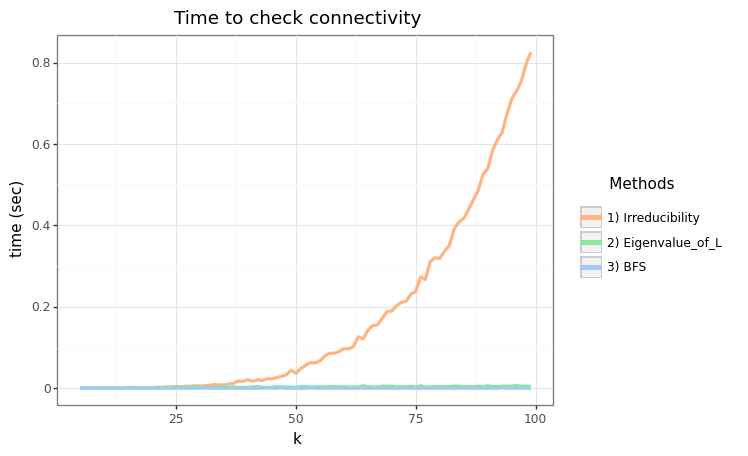

<ggplot: (138943826107)>

In [29]:
line_size = 1.3

( ggplot(time_data) +
  aes(x='k') +
  geom_line(aes(y='Irreducibility', color = '"#FFB482"'), size = line_size) +
  geom_line(aes(y='Eigenvalue_of_L', color = '"#8DE5A1"'), size = line_size) +
  geom_line(aes(y='BFS', color = '"#A1C9F4"'), size = line_size) +
  labs(x='k', y='time (sec)', title = 'Time to check connectivity') + 
  theme_bw() + 
  scale_color_identity(guide='legend', name = '      Methods \n\n ', breaks=['#FFB482','#8DE5A1','#A1C9F4'],
                       labels=['1) Irreducibility','2) Eigenvalue_of_L','3) BFS']))


Given that we found that the method 3 is the fastest, we use it to check connectivity for the next point.

## 4) 

In [82]:
def estimate_pc_er(seq_p, k, num_instances):
    pc_list = []
    for p in tqdm(seq_p):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.erdos_renyi_graph(k, p)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
k = 100
num_instances = 100
seq_p = np.linspace(0, 1, num=100)

# Estimate pc for Erdos-Reyni graphs.
pc_er = estimate_pc_er(seq_p, k, num_instances)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


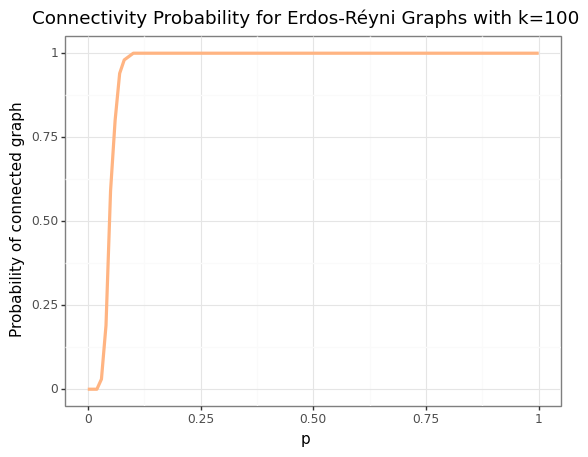

<ggplot: (318270798)>

In [85]:
# Plot pc vs p for Erdos-Reyni graphs.
( ggplot(aes(x = seq_p, y = pc_er))+
  labs(x='p',
       y='Probability of connected graph',
       title = 'Connectivity Probability for Erdos-Réyni Graphs with k=100') +
  geom_line(size=line_size, color = '#FFB482') +
  theme_bw())#.draw()

In [86]:
def estimate_pc_regular(r, k, num_instances):
    pc_list = []
    for k_val in tqdm(range(r+1, k+1)):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.random_regular_graph(r, k_val)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
r_values = [2, 8]
num_instances = 200
k = 100

# Estimate pc for regular random graphs.
pc_reg = []
for r in r_values:
    pc_r = estimate_pc_regular(r, k, num_instances)
    pc_reg.append(pc_r)

100%|██████████| 92/92 [00:22<00:00,  4.10it/s]


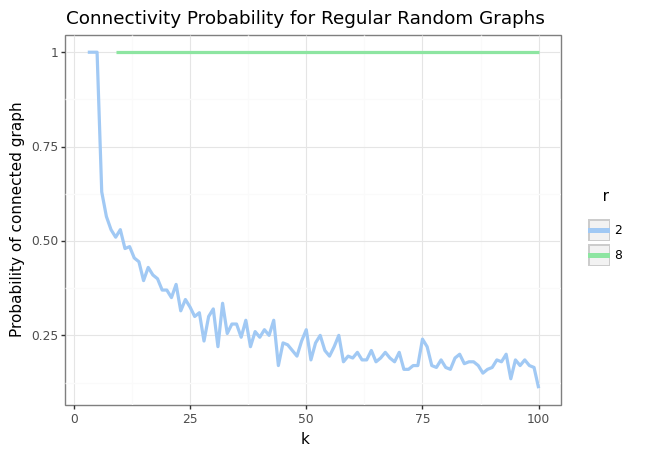

<ggplot: (317267293)>

In [87]:
# Plot pc vs k for regular random graphs.
( ggplot() +
  aes(x = np.arange(r_values[0]+1, k+1)) +
  labs(x='k',
        y='Probability of connected graph',
        title = 'Connectivity Probability for Regular Random Graphs') +
  geom_line(aes(y=pc_reg[0], color = '"#A1C9F4"'), size=line_size) +
  geom_line(aes(x = np.arange(r_values[1]+1, k+1),y= pc_reg[1], color='"#8DE5A1"'), size=line_size ) +
  theme_bw() +
  scale_color_identity(guide='legend', name = '   r \n\n ', breaks=['#A1C9F4','#8DE5A1'], labels=['2','8']))#.draw()

## Part 2

1. Select N servers that are closest to server A in the given Data Center network topology. These servers are numbered from 1 to N based on their hop count from server A.

2. Split the computation job into N parallel tasks, each of which is assigned to one of the N servers.

3. For each server i (i = 1, ..., N), calculate the time Ti required to transfer data to and from server A using the TCP connection with average throughput θi. Ti is calculated as Ti = 2τhi, where hi is the number of hops between server A and server i.

4. For each server i (i = 1, ..., N), calculate the time Xi required to run the computation task assigned to that server. Xi is a negative exponential random variable with mean E[Xi] = E[X]/N.

5. For each server i (i = 1, ..., N), calculate the amount of data Li that is transferred to and from server i. Li is equal to Lf/N.

6. For each server i (i = 1, ..., N), calculate the amount of output data Lo,i produced by that server, which is uniformly distributed in the interval [0, 2Lo/N].

7. Calculate the completion time Ri for each server i as the sum of Ti, Xi, and the time required to transfer the output data Lo,i back to server A.

8. The response time R is defined as the maximum completion time among all servers, since the output of the job is available only when all servers have delivered their output files to server A.

9. Repeat steps 2-8 multiple times to obtain a sample of response times.

10. Calculate the mean response time by averaging the sample of response times obtained in step 9.

11. The Job running cost S can be evaluated using the mean response time E[R] and the average server time used to run the job E[Θ]. The value of E[Θ] depends on whether the job runs locally on server A or is split into N tasks and run on N servers. If the job runs locally on A, then E[Θ] is equal to the time taken to run the job on server A. Otherwise, E[Θ] is the sum of the times taken to run the N tasks on the N servers. The value of S can be calculated as S = E[R] + ξ E[Θ], where ξ is a parameter that represents the cost of using server A relative to the cost of using the other N servers.

## Jellyfish Networks 

- S $\longrightarrow$ switches
- S(n-r) $\longrightarrow$ maximum number of servers
- n $\longrightarrow$ number of ports for each switch
- r $\longrightarrow$ number of ports of a switch dedicated to other switches
- (n-r) $\longrightarrow$ number of ports of a switch dedicated to servers

In [117]:
### TODO creare grafo random con al massimo 32 archi per ogni nodo
### il numero di nodi deve essere pari al numero di switch
### trovare il cammino minimo tra tutti i nodi del grafo e aggiungere 2 ad ogni cammino 
### trovo valore atteso di hops

import random

n = 64
S = 5*(n**2)
G_jelly = nx.Graph()
for i in range(S):
    G_jelly.add_node(i, type= 'switch')
max_degree = 32
for i in range(S):
    degree = random.randint(1, max_degree)
    nodes_to_connect = random.sample(range(S), degree)
    for j in nodes_to_connect:
        if i != j and not G_jelly.has_edge(i, j):
            G_jelly.add_edge(i, j)
# node_attributes = {node: {'type': 'switch'} for node in G_jelly.nodes}
# nx.set_node_attributes(G_jelly, node_attributes)

In [121]:
count_switch = sum(1 for node in G_jelly.nodes(data=True) if node[1].get('type') == 'switch')
print(f'Number of switches: {count_switch}')

Number of switches: 20480


## Fat-tree Networks

- Switches $\longrightarrow 5 \cdot n^2$
- Servers $\longrightarrow n^3$

In [97]:
import fnss

def fat_tree(k):
    fnss.DatacenterTopology.node = property(lambda self: self.nodes)
    return fnss.fat_tree_topology(k)

In [114]:
G_ft = fat_tree(n)
count_host = sum(1 for node in G_ft.nodes(data=True) if node[1].get('type') == 'host')
count_switch = sum(1 for node in G_ft.nodes(data=True) if node[1].get('type') == 'switch')
print(f'Number of servers: {count_host}')
print(f'Number of switches: {count_switch}')

Number of servers: 65536
Number of switches: 5120
